ML project. Data and one ML method.

In [1]:
import json
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt  # For visualizations
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,  mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split 


Settings

In [2]:
datafile = 'stdata16.json'
Xcol = 'velocity' 
EFUNC = 'MSE'

Function to read and convert data from JSON to list object

In [3]:
 def get_json_data(datafile):
    f = open(datafile)
    data = json.load(f)

    l = []
    n = 0

    for i in data['locations']:
    #    print(i)
        for k in data['heartrates']:
            if k["d"] == i["d"]:
                #print(i)
                #print(k)
                kmh = (int(i['v']) * 36) / 1000
                min = datetime.timedelta(seconds = (int(i['t'])))
                mins = str(min)
                #print(type(mins), ' ', mins)
                l.append({'time h:m:s':mins, 'speed m/s':int(i['v'])/100, 'heartrate':k['hr'], 'time':k['t'], 'distance':i['s'], 'velocity': kmh})
                n = n +1
                break
    f.close()
    return l


In [4]:
def error_function(y, y_pred):
    if EFUNC == 'MAE':
        return mean_absolute_error(y, y_pred)
    return mean_squared_error(y, y_pred)   

Code starts. Read data to dataframe object and convert to feature X and label y

In [5]:
TO = 10

df = DataFrame(get_json_data(datafile))

print(df.loc[0:TO])
#print(df.tail(5))
print('\nDatapoints: ', len(df)) # , ' ', type(l))

#data = df[['time'] + ['distance'] + ['velocity']]
#print(data.loc[0:TO])
#X = df[['time'] + ['velocity']].to_numpy(dtype='float').reshape(-1, 2)

X = np.array(df[Xcol]).reshape(-1, 1)
y = np.array(df['heartrate'])
#print('X:', type(X), ' ',X.shape, ' y: ', y.shape)
#print('X:', X[:10])




   time h:m:s  speed m/s  heartrate  time  distance  velocity
0     0:00:01       0.00        109     1         0     0.000
1     0:00:02       0.00        109     2         0     0.000
2     0:00:03       0.00        109     3        15     0.000
3     0:00:09       3.70        107     9        24    13.320
4     0:00:55       1.48         98    55        32     5.328
5     0:01:01       1.50         96    61        42     5.400
6     0:01:07       1.58         96    67        51     5.688
7     0:01:13       1.51         97    74        60     5.436
8     0:01:20       0.93        100    81        68     3.348
9     0:01:28       1.36        101    89        77     4.896
10    0:01:37       1.28        105    98        86     4.608

Datapoints:  1855


Plot raw data.

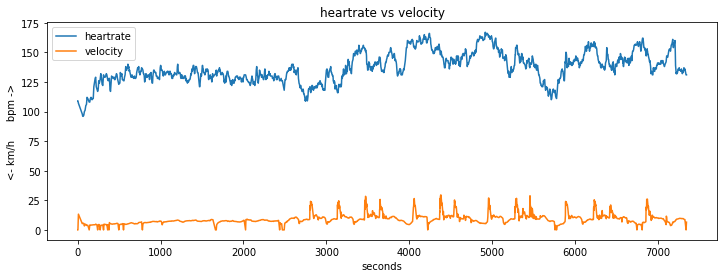

In [6]:
plt.figure(figsize=(12, 4))

plt.plot(df['time'], df['heartrate'],label = 'heartrate')
plt.plot(df['time'], df['velocity'], label = 'velocity')
plt.legend(loc = 'upper left')

plt.xlabel('seconds')
plt.ylabel('<- km/h      bpm ->')
plt.title('heartrate vs velocity')
plt.show()

 Visualize data

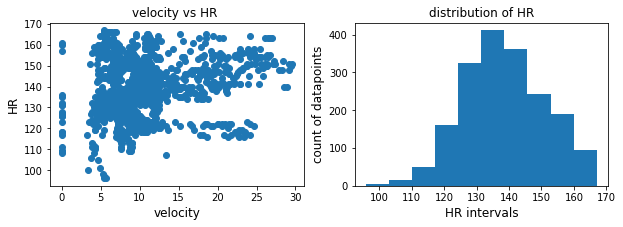

In [7]:
# Visualize data
fig, axes = plt.subplots(1, 2, figsize=(10,3)) # create a figure with two axes (1 row,2 columns) on it
axes[0].scatter(df['velocity'],df['heartrate'])
axes[0].set_xlabel("velocity",size=12)
axes[0].set_ylabel("HR",size=12)
axes[0].set_title("velocity vs HR ",size=12)

axes[1].hist(df['heartrate']) # plot a hist plot to show the distribution of HR
axes[1].set_title('distribution of HR',size=12)
axes[1].set_ylabel("count of datapoints",size=12)
axes[1].set_xlabel("HR intervals",size=12)
plt.show()

Scatter plot to show relation between the features and the heartrate"

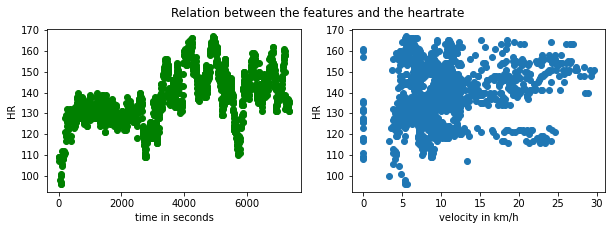

In [8]:
fig = plt.figure(figsize=(10,3))
fig.suptitle("Relation between the features and the heartrate")
plt.subplot(1,2,1)
plt.scatter(df['time'], y, c="green")
plt.xlabel('time in seconds')
plt.ylabel('HR')
plt.subplot(1,2,2)
plt.scatter(df['velocity'], y) # , c="green")
plt.xlabel('velocity in km/h')
plt.ylabel('HR')
plt.show()

Analyze data for outliers by standard deviation. Lower and upper limits are 3 times standard deviation below and above the mean value.

In [9]:
# identify outliers with standard deviation
from numpy import mean
from numpy import std

CUT_OFF_FACTOR = 3

# mean and standard deviation
odata = y # X
omean, ostd = mean(odata), std(odata)

cut_off = ostd * CUT_OFF_FACTOR
print('mean: ', omean, '  std dev: ', ostd, ' cut_off: ', cut_off)
lower, upper = omean - cut_off, omean + cut_off
print('lower: ', lower, '  upper: ', upper)

outliers = [x for x in odata if x < lower or x > upper]
print('outliers: %d' % len(outliers))

outliers_none = [x for x in odata if x >= lower and x <= upper]
print('non-outliers: %d' % len(outliers_none))

mean:  138.35040431266847   std dev:  12.318597191391355  cut_off:  36.955791574174064
lower:  101.3946127384944   upper:  175.30619588684254
outliers: 6
non-outliers: 1849


Linear regression

In [10]:
lr = LinearRegression()
lr = lr.fit(X, y)
y_pred = lr.predict(X)
tr_error = error_function(y, y_pred)
print(y[0:10])
print(y_pred[0:10])

print('Training error: ', tr_error)
print('w1: ', lr.coef_) # learnt W1
print('w0: ', lr.intercept_) # learnt W0


[109 109 109 107  98  96  96  97 100 101]
[131.78547589 131.78547589 131.78547589 140.33852171 135.20669422
 135.2529269  135.43785762 135.27604324 133.93529552 134.92929814]
Training error:  142.14771228688883
w1:  [0.64212056]
w0:  131.7854758919864


Plot real y vs preditced y

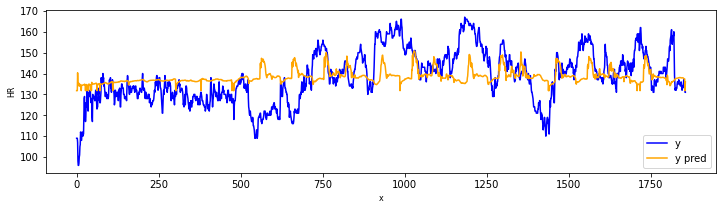

In [11]:
tr_diff = [y_pred[x] - y[x] for x in range(len(y))]
tr_diff2 = [(y_pred[x] - y[x])**2 for x in range(len(y))]
plt.figure(figsize=(12, 3))  
xf = np.linspace(0, len(y), len(y))
plt.plot(xf, y, color='b', label='y')  
plt.plot(xf, y_pred, color='orange', label='y pred')  
plt.xlabel('x',size=8)
plt.ylabel('HR',size=8)
plt.legend(loc="lower right")
plt.show() 


Visualize

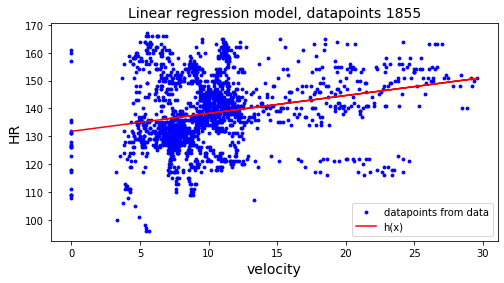

In [12]:
plt.figure(figsize=(8,4))
plt.scatter(X, y, color='b', s=8, label='datapoints from data')

plt.plot(X, y_pred, color='r', label='h(x)')

xs = 14 # 15
plt.xlabel(Xcol,size=xs)
plt.ylabel('HR',size=xs)

plt.title('Linear regression model, datapoints {:}'.format(len(X)) , size=xs)

plt.legend(loc='best', fontsize=10)

plt.show()
         

Function for training with different size of data

In [13]:
def TrainingWithDifferentDatasizeNPlot(X, y, degree):
    trainingset_size = [0.2, 0.5, 0.7, 1.0]    # training set sizes
    colors = ['green', 'b', 'r', 'yellow'] # , 'y', 'brown', 'black']
    
    tr_errors = []       
    
    #print("\nNumber of datapoints in whole set: ",len(X))
    plt.figure(figsize=(8, 4))

    for i in range(len(trainingset_size)):  
        index = np.arange(int(len(X)*trainingset_size[i]))
        #print("\nNumber of datapoints in this subset: ",len(index), " / ", len(X))
        #print('index: ', index, 'x len:', len(X), ' y len :' , len(y))

        X_sub = X[index]    # obtain a subset
        y_sub = y[index]    # subset of label
        #print('X_sub: ', X_sub[-10:])
        #print('y_sub: ', y_sub[-10:])

        poly = PolynomialFeatures(degree=degree, include_bias = True)
        X_poly = poly.fit_transform(X_sub)
        #print('X_poly.shape: ', X_poly.shape)
        #print('X.shape: ', X.shape) # , ' ', X)
        #print('y_sub.shape: ', y_sub.shape) # , ' ', y_sub)
        #print('y_sub.shape: ', y_sub.reshape(-1,1).shape) # , ' ', y_sub)

        lin_regr = LinearRegression(fit_intercept=False)
        lin_regr = lin_regr.fit(X_poly, y_sub)

        y_pred = lin_regr.predict(X_poly) 
    
        tr_error = error_function(y_sub, y_pred)
        tr_errors.append(tr_error)

        X_fit = np.linspace(X_sub.min(), X_sub.max(), 50)

        t = 'h(x) {} datapoints'.format(len(index))
        plt.plot(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), color=colors[i], label=t)
        
    plt.scatter(X, y, color='b', s=10, label="Datapoint") 
    plt.xlabel(Xcol)    
    plt.ylabel('HR')
    plt.legend(loc="best")  
    plt.title('Polynomial degree {}\n'.format(degree))
    #plt.title('Training error = {:.5}'.format(tr_error))  
    plt.show()    # show the plot

    #print('X_poly.shape[1]:', X_poly.shape[1])
    #print('tr_errors: ' , len(tr_errors))
    #print('last tr_error: ' , str(tr_error))
    #print('tr_errors: ' , tr_errors)


Fit polynomial regression with varying degrees and varying amount of data to see the effect of 
number of data points.

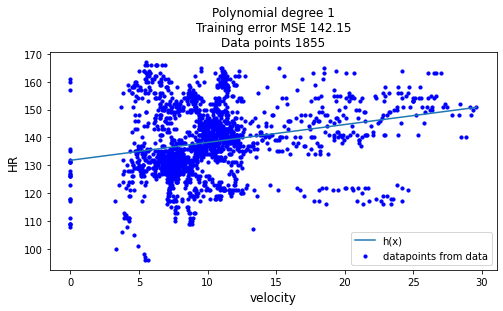

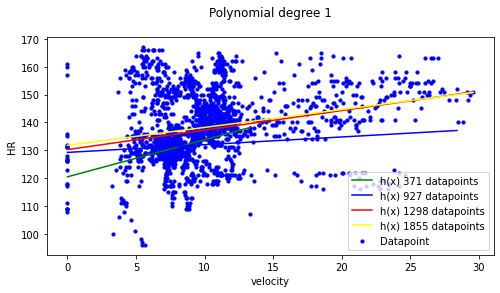

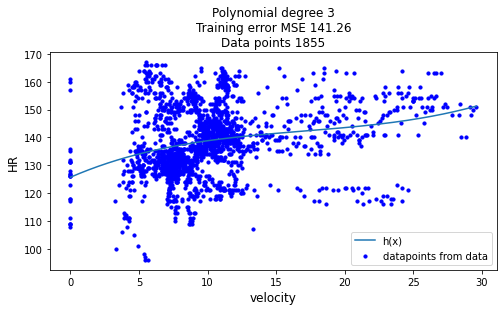

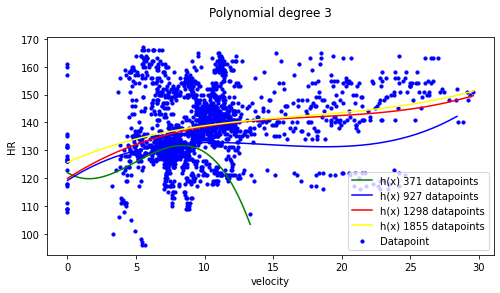

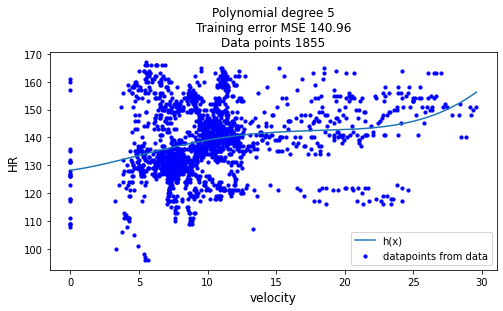

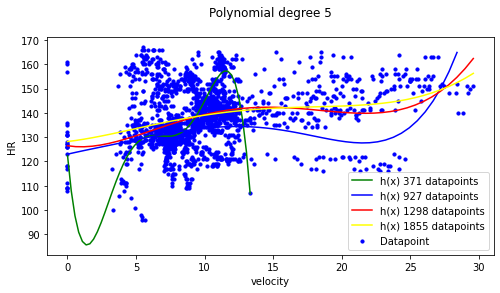

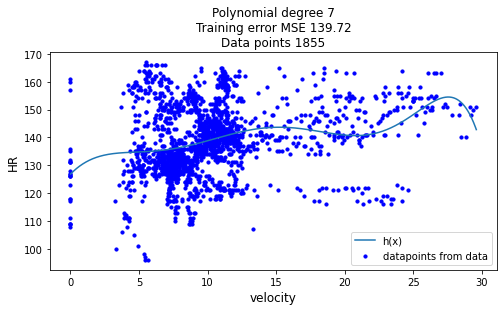

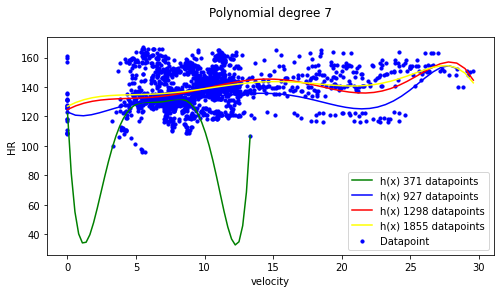

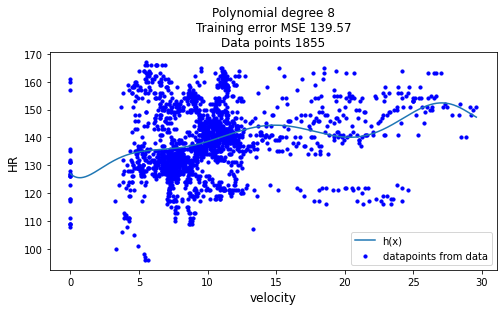

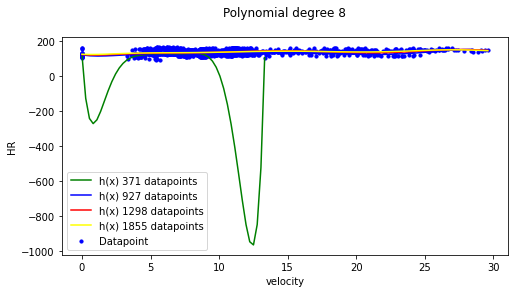

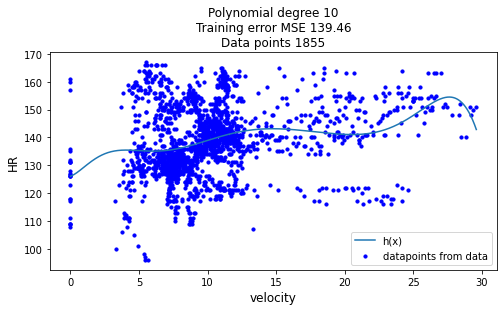

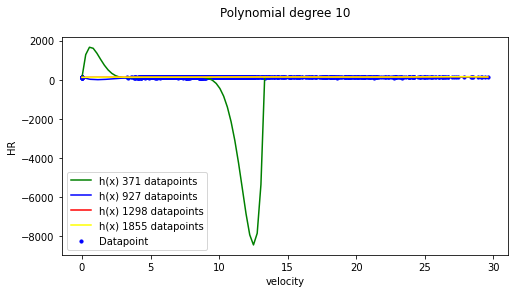

In [14]:
degrees = [1,3,5,7,8,10]
tr_errors = []


for i in range(len(degrees)):
    #print(i , ': Polynomial degree: ', degrees[i])
    
    poly = PolynomialFeatures(degree=degrees[i], include_bias = True)
    X_poly = poly.fit_transform(X)
    
    lin_rg = LinearRegression(fit_intercept=False)
    lin_rg= lin_rg.fit(X_poly, y)
    
    y_pred = lin_rg.predict(X_poly)
    tr_error = error_function(y, y_pred)
    #print('Training error: ', tr_error)
    
    #print('The first 2 of X_poly:\n', X_poly[0:2])
    #print('The learned weights:\n', lin_rg.coef_)
    
    tr_errors.append(tr_error)
    
    plt.figure(figsize=(8, 4))
    X_fit = np.linspace(X.min(), X.max(), X.size) # 50)
    #print('X_fit:\n', X_fit)
    
    plt.plot(X_fit, lin_rg.predict(poly.transform(X_fit.reshape(-1,1))), label='h(x)')
    
    plt.scatter(X, y, color='b', s=10, label='datapoints from data')

    # original and predicted values
    #plt.plot(X_fit, y, color='orange', label='y')  
    #plt.plot(X_fit, y_pred, color='green', linewidth=3, label='y pred')     
    
    xs = 12 # 15
    plt.xlabel('{}'.format(Xcol),size=xs)
    plt.ylabel('HR',size=xs)
    plt.title('Polynomial degree {}\nTraining error {} {:.5}\nData points {}'.format(degrees[i], EFUNC, tr_error, len(X)))
    plt.legend(loc='best', fontsize=10)

    plt.show()
    
    TrainingWithDifferentDatasizeNPlot(X, y, degrees[i])
    

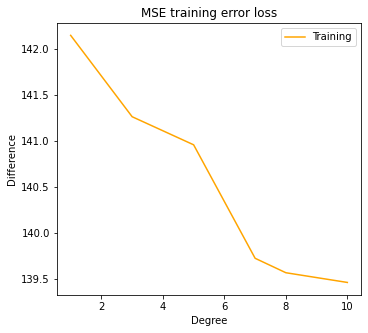

In [15]:
#plt.figure(figsize=(8, 5))
#print('tr:',tr_errors)
#print('val:', val_errors)

fig = plt.figure(figsize=(12,5))
#fig.suptitle("Train vs validation loss")
plt.subplot(1,2,1)
plt.plot(degrees, tr_errors, label = 'Training', c='orange')
plt.legend(loc = 'upper right')
plt.xlabel('Degree')
plt.ylabel('Difference')
t = '{} training error loss'.format(EFUNC)
#t = (f'Polynomial degree = {degree}\nTraining error {EFUNC} = {tr_error:.5}\nValidation error = {val_error:.5}\nDiff = {abs(tr_error-val_error):.5}')  
plt.title(t)

plt.show()

Separate training and validation data

X_train:  (1298, 1) X_val:  (557, 1) X:  (1855, 1)
X_val / x:  0.30026954177897575


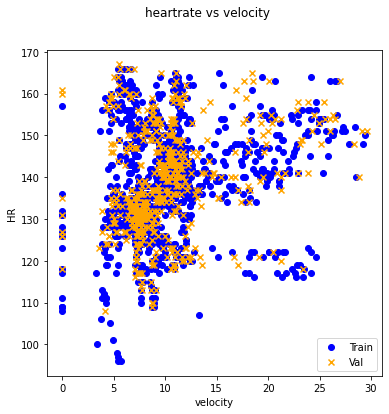

In [16]:
TEST_SIZE = 0.3

X = np.array(df[Xcol]).reshape(len(df), 1)

 # training and valdation data set split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
print('X_train: ', X_train.shape, 'X_val: ', X_val.shape, 'X: ', X.shape)
print('X_val / x: ', X_val.shape[0]/X.shape[0]) #, 'X_val: ', X_val.shape)

fig = plt.figure(figsize=(6,6))
fig.suptitle("heartrate vs {} ".format(Xcol))
#plt.subplot(1,2,1)
plt.scatter(X_train, y_train, color = 'b', marker='o', label='Train')
plt.scatter(X_val, y_val,  color = 'orange', marker='x', label='Val')
plt.xlabel(Xcol)
plt.ylabel('HR')
plt.legend(loc='lower right', fontsize=10)
plt.show()

Training and validation

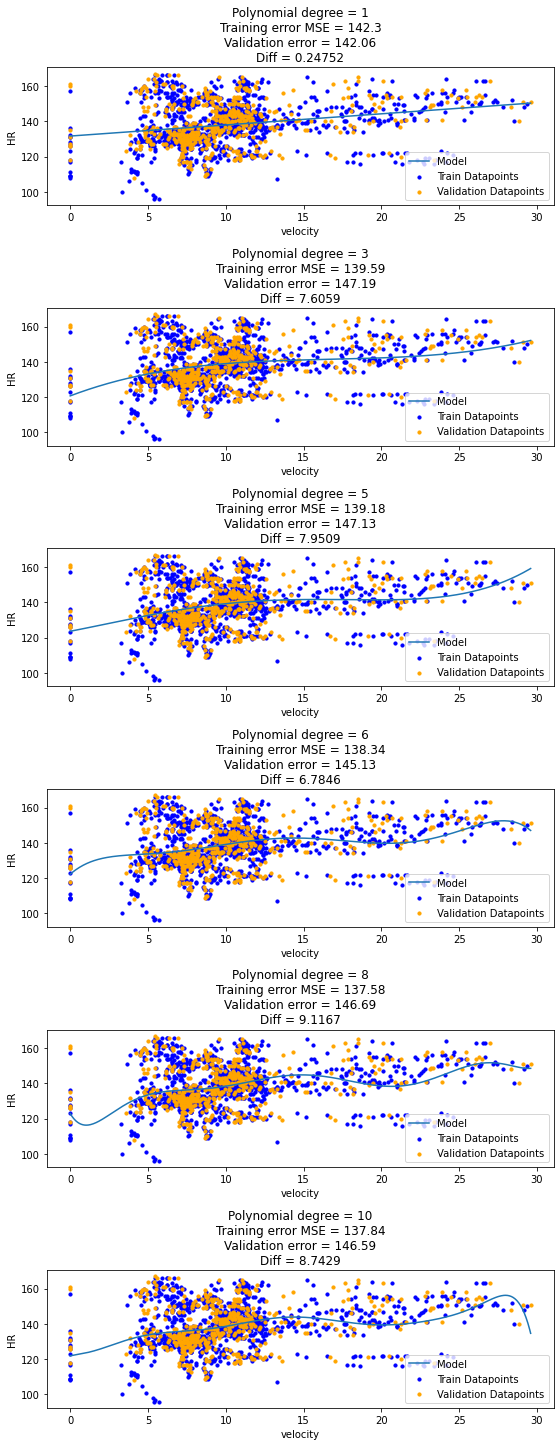

In [17]:
# polynomial degree 
degrees = [1, 3, 5, 6, 8, 10]    

tr_errors = []          
val_errors = []
difference = []
diff = {}

plt.figure(figsize=(8, 20))   
for i, degree in enumerate(degrees):
    plt.subplot(len(degrees), 1, i + 1) 
    
    lin_regr = LinearRegression(fit_intercept=False)
    # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly
 
    poly = PolynomialFeatures(degree=degree)   
    X_train_poly = poly.fit_transform(X_train)   
    lin_regr.fit(X_train_poly, y_train)    # apply linear regression
    
    y_pred_train = lin_regr.predict(X_train_poly) 
    tr_error = error_function(y_train, y_pred_train)
    #print('The training error is: ', tr_error)    # print the training error
      
    X_val_poly = poly.fit_transform(X_val) 
    y_pred_val = lin_regr.predict(X_val_poly) 
    val_error = error_function(y_val, y_pred_val)
    #print('The validation error is: ', val_error)  
        
    tr_errors.append(tr_error)
    val_errors.append(val_error)
    
    diff[i] = {'Degree': degree, 'Difference': abs(tr_error-val_error)}
    difference.append(abs(tr_error-val_error))

    X_fit = np.linspace(X.min(), X.max(), 500)    # generate samples
    plt.tight_layout()
    plt.plot(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), label="Model")    # plot the polynomial regression model
    plt.scatter(X_train, y_train, color="b", s=10, label="Train Datapoints") 
    plt.scatter(X_val, y_val, color="orange", s=10, label="Validation Datapoints")
    plt.xlabel('{}'.format(Xcol)) 
    plt.ylabel('HR')
    plt.legend(loc="best") 
    plt.title(f'Polynomial degree = {degree}\nTraining error {EFUNC} = {tr_error:.5}\nValidation error = {val_error:.5}\nDiff = {abs(tr_error-val_error):.5}')  
plt.show()   


Training and validation hypothesis h(x) maps

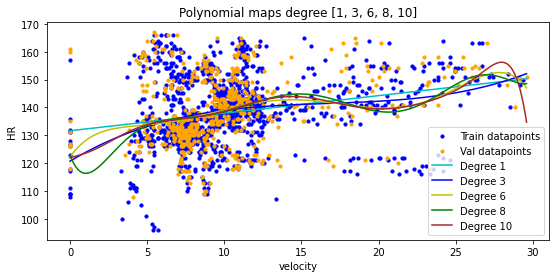

In [18]:
# polynomial degree 
#degrees = [1, 3, 5, 6, 8, 10]    
#colors = ['c', 'b', 'r', 'y', 'g', 'brown', 'black']
degrees = [1, 3, 6, 8, 10]    
colors = ['c', 'b', 'y', 'g', 'brown', 'black']

tr_errors = []          
val_errors = []
difference = []
diff = {}

plt.figure(figsize=(9, 4))   
plt.scatter(X_train, y_train, color="b", s=10, label="Train datapoints") 
plt.scatter(X_val, y_val, color="orange", s=10, label="Val datapoints")
plt.xlabel('{}'.format(Xcol)) 
plt.ylabel('HR')
plt.title(f'Polynomial maps degree {degrees}')

for i, degree in enumerate(degrees):
    
    lin_regr = LinearRegression(fit_intercept=False)

    poly = PolynomialFeatures(degree=degree)   
    X_train_poly = poly.fit_transform(X_train)   
    lin_regr.fit(X_train_poly, y_train)  
    
    y_pred_train = lin_regr.predict(X_train_poly) 
    tr_error = error_function(y_train, y_pred_train)
    #print('The training error is: ', tr_error) 
      
    X_val_poly = poly.fit_transform(X_val) 
    y_pred_val = lin_regr.predict(X_val_poly) 
    val_error = error_function(y_val, y_pred_val)
    #print('The validation error is: ', val_error)  
        
    tr_errors.append(tr_error)
    val_errors.append(val_error)
    
    diff[i] = {'Degree': degree, 'Difference': abs(tr_error-val_error)}
    difference.append(abs(tr_error-val_error))

    X_fit = np.linspace(X.min(), X.max(), 500)  
    label = 'Degree {}'.format(degree)
    plt.plot(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), label=label, color=colors[i])    # plot the polynomial regression model
    
plt.legend(loc = 'lower right')
plt.show()

{'Degree': 1, 'Difference': 0.24751807337008813}
{'Degree': 3, 'Difference': 7.605923773526598}
{'Degree': 6, 'Difference': 6.784555099701947}
{'Degree': 8, 'Difference': 9.116694590603345}
{'Degree': 10, 'Difference': 8.74288566094367}


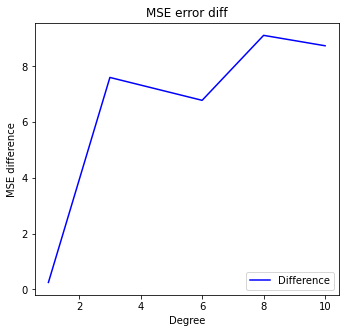

In [19]:
for k in range(len(diff)):
    print(diff[k])
    
fig = plt.figure(figsize=(12,5))
#fig.suptitle("Degree vs train and validation error differene")
plt.subplot(1,2,1)
plt.plot(degrees, difference,label = 'Difference', c='blue')
plt.legend(loc = 'lower right')
plt.xlabel('Degree')
t = '{} difference'.format(EFUNC)
plt.ylabel(t)
t = '{} error diff'.format(EFUNC)
plt.title(t)

plt.show()

In [20]:
dfe =  pd.DataFrame({ 'degree': degrees
                    , 'training error': tr_errors
                    , 'validation error': val_errors
                    , 'difference': [abs(tr_errors[i] - val_errors[i]) for i in range(len(tr_errors))]
                    })
print(dfe)

   degree  training error  validation error  difference
0       1      142.304291        142.056773    0.247518
1       3      139.585918        147.191842    7.605924
2       6      138.340926        145.125481    6.784555
3       8      137.575119        146.691814    9.116695
4      10      137.844153        146.587039    8.742886


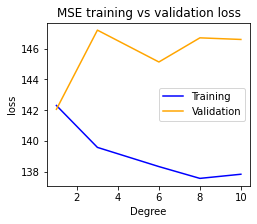

In [21]:
#plt.figure(figsize=(8, 5))
#print('tr:',tr_errors)
#print('val:', val_errors)

fig = plt.figure(figsize=(8,3))
#fig.suptitle("Train vs validation loss")
plt.subplot(1,2,1)
plt.plot(degrees, tr_errors, label = 'Training', c='blue')
plt.plot(degrees, val_errors,label = 'Validation', c='orange')
plt.legend(loc = 'center right')
plt.xlabel('Degree')
plt.ylabel('loss')
t = '{} training vs validation loss'.format(EFUNC)
#t = (f'Polynomial degree = {degree}\nTraining error {EFUNC} = {tr_error:.5}\nValidation error = {val_error:.5}\nDiff = {abs(tr_error-val_error):.5}')  
plt.title(t)

plt.show()